In [3]:
import pandas as pd
data = pd.read_csv('Titanic-Dataset.csv')
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
#✅ Insight:

#The dataset loaded successfully, showing key columns like Survived, Pclass, Name, Sex, Age, Fare, etc.
#The data includes both numerical and categorical columns — great variety for EDA.

In [5]:
#checked the missing values
print(data.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
#✅ Insight:

#Age has 177 missing values — that's quite significant for analysis.
#Cabin has 687 missing values (a lot!). This column may require dropping or special handling.
#Embarked has 2 missing values — small enough to impute with the mode (most common value).

In [7]:
#clean up the missing values
#for ages we have 177 missing values
data['Age'].fillna(data['Age'].mean(), inplace=True)
#for cabin we have 687 missing values — too many to fix without losing accuracy. better to drop
data.drop('Cabin', axis=1, inplace=True)
#for embarked only 2 is missing
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)




In [8]:
# Checking duplicates
print(data.duplicated().sum())

# If any duplicates exist, drop them
data = data.drop_duplicates()


0


In [9]:
print(data.isnull().sum())


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [10]:
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

In [11]:
#Feature Engineering
#Converting Categorical Data
#Let’s encode 'Sex' and 'Embarked' into numbers
from sklearn.preprocessing import LabelEncoder

data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
#Creating New Features (it is Optional but it boosts performance)
#FamilySize: Combine SibSp and Parch to reflect family groups:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
#IsAlone: Detect if someone’s traveling alone:
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)


In [12]:
print(data.columns)
#Looks like the original 'Embarked' column has already been one-hot encoded into 'Embarked_Q' and 'Embarked_S',
#and the original column was likely dropped. That’s why the error popped up — pd.get_dummies() can’t find it.



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked_Q', 'Embarked_S', 'FamilySize',
       'IsAlone'],
      dtype='object')


In [13]:
#Feature Scaling
#For models like Logistic Regression or KNN, scale numerical columns:
from sklearn.preprocessing import StandardScaler
# normalizing numeric columns
num_cols = ['Age', 'Fare', 'FamilySize']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])


In [14]:
#Spliting data into train/test:
from sklearn.model_selection import train_test_split

X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


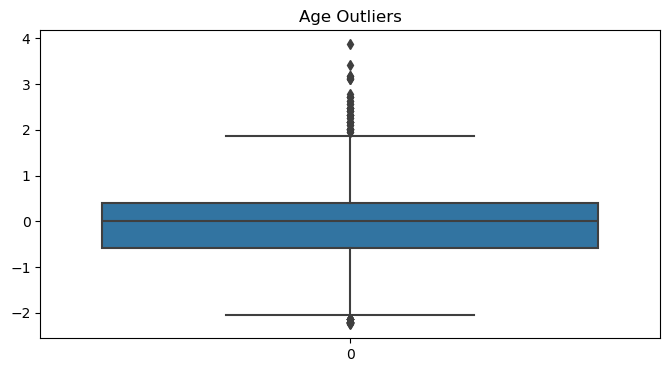

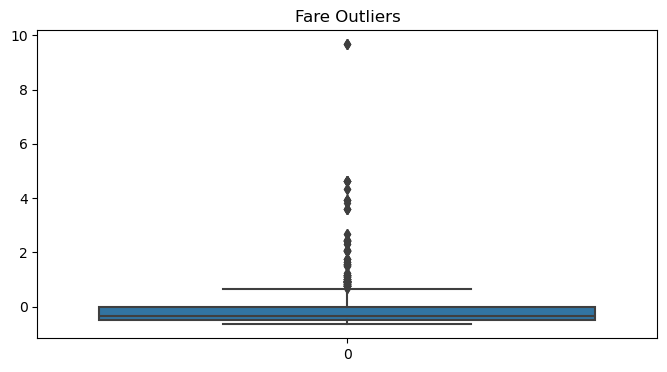

In [15]:
#Detecting Outliers
# points far from the whiskers, those are the outliers.
import seaborn as sns
import matplotlib.pyplot as plt

# Check Age outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data['Age'])
plt.title('Age Outliers')
plt.show()

# Check Fare outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data['Fare'])
plt.title('Fare Outliers')
plt.show()


In [16]:
#🎯 Boxplots for Outliers (Age & Fare):
#Age Outliers:
#The boxplot for Age reveals a few outliers on the lower end — likely infants or very young children. This suggests that most passengers were adults, with a few younger outliers deviating from the bulk of data.

#Fare Outliers:
#The Fare boxplot shows several outliers on the upper end, indicating that some passengers paid significantly higher fares — probably those traveling in first class or in luxury accommodations. These high fares might correlate with survival, as wealthier passengers were more likely to secure lifeboat spots.



In [17]:
#Identifying and managing outliers:
#Using Interquartile Range (IQR) method on Age, Fare, and FamilySize to detect and handle outliers:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check outliers for numeric columns
outliers_fare = detect_outliers_iqr(data, 'Fare')
outliers_age = detect_outliers_iqr(data, 'Age')

# Option 1: Cap outliers instead of removing (preserves data size)
data['Fare'] = data['Fare'].clip(upper=data['Fare'].quantile(0.95))
data['Age'] = data['Age'].clip(upper=data['Age'].quantile(0.95))


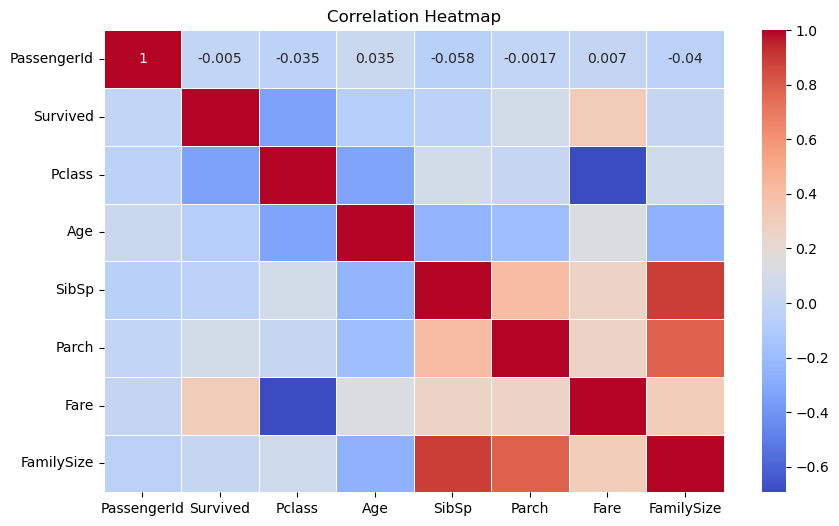

In [18]:
#Handling non-numeric columns before correlation


# Selecting only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Now create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


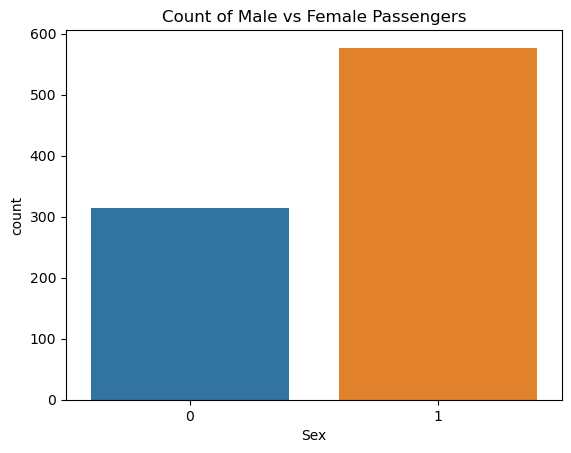

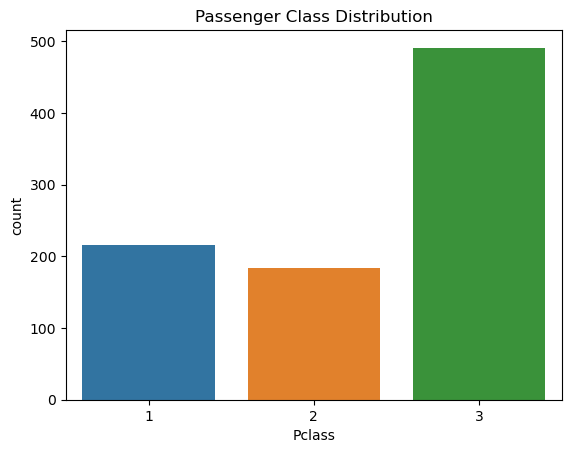

In [19]:
#visualizations

#Bar charts for categorical variables:

import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart for 'Sex'
sns.countplot(x='Sex', data=data)
plt.title('Count of Male vs Female Passengers')
plt.show()

# Bar chart for 'Pclass'
sns.countplot(x='Pclass', data=data)
plt.title('Passenger Class Distribution')
plt.show()



In [20]:
#🚹🚺 Bar Plot: Gender Distribution
#✅ Insight:

#The plot likely shows more males than females on board.
#This could relate to survival rates — Titanic survival rates varied by gender.
    
#🛳️ Bar Plot: Passenger Class Distribution
#✅ Insight:

#More passengers traveled in 3rd class than 1st or 2nd class.
#This hints that socio-economic factors might affect survival rates.


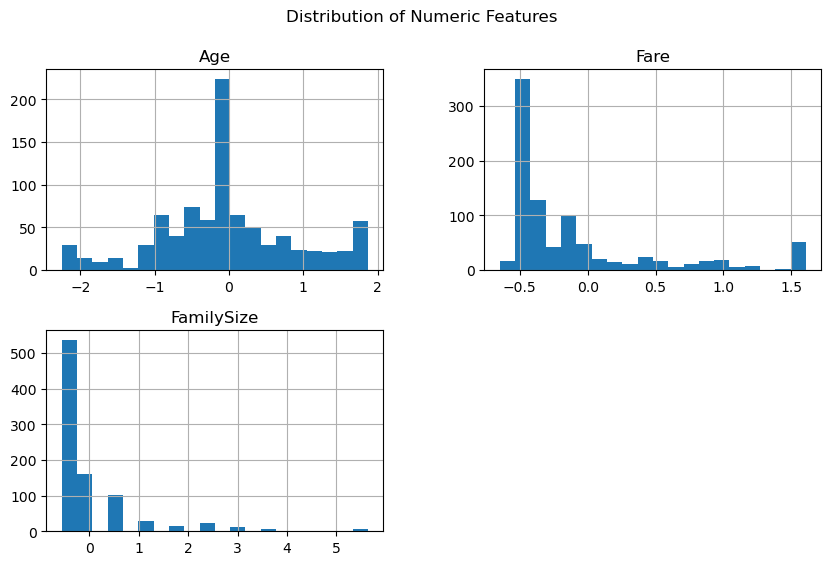

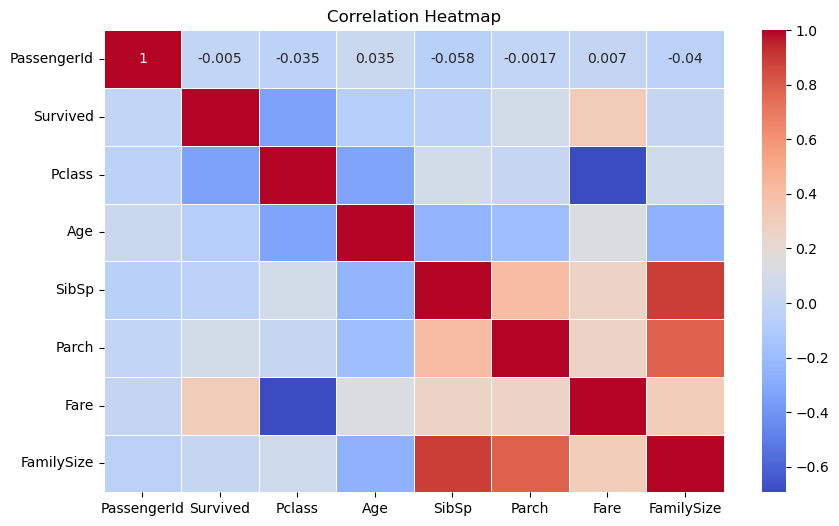

In [21]:
#Histograms for numeric distributions:
# Histograms for Age, Fare, FamilySize
data[['Age', 'Fare', 'FamilySize']].hist(bins=20, figsize=(10, 6))
plt.suptitle('Distribution of Numeric Features')
plt.show()

#Correlation heatmap:

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [22]:
#🔥 Histogram: Age Distribution

#✅ Insight:

#The age distribution is right-skewed, with more young adults and fewer elderly passengers.
#Might reveal age groups more likely to survive.

#💰 Histogram: Fare Distribution

#✅ Insight:

#Fare data seems right-skewed, with some high outliers (first-class luxury tickets).
#Could be worth checking if higher fares link to better survival odds.

#🔗 Correlation Heatmap

#✅ Insight:

#Survived correlates negatively with Pclass (1st class had better survival chances).
#Fare positively correlates with survival — richer passengers had better odds.
#Age has a weak correlation — survival wasn’t strictly age-based.


C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

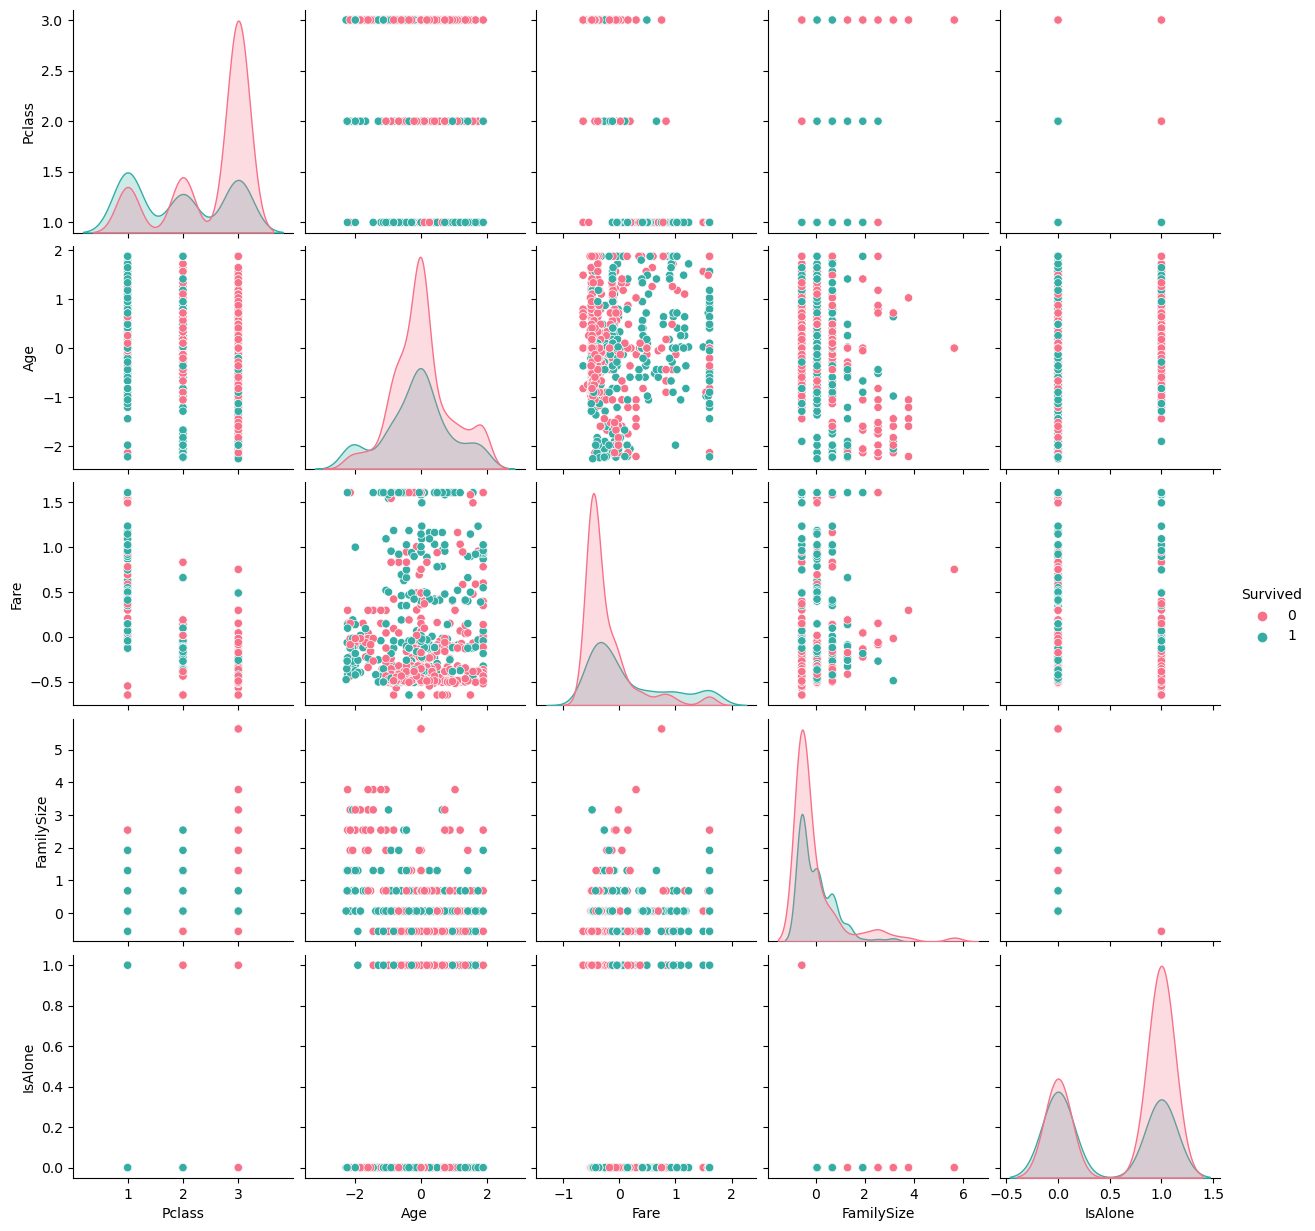

C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PMYLS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

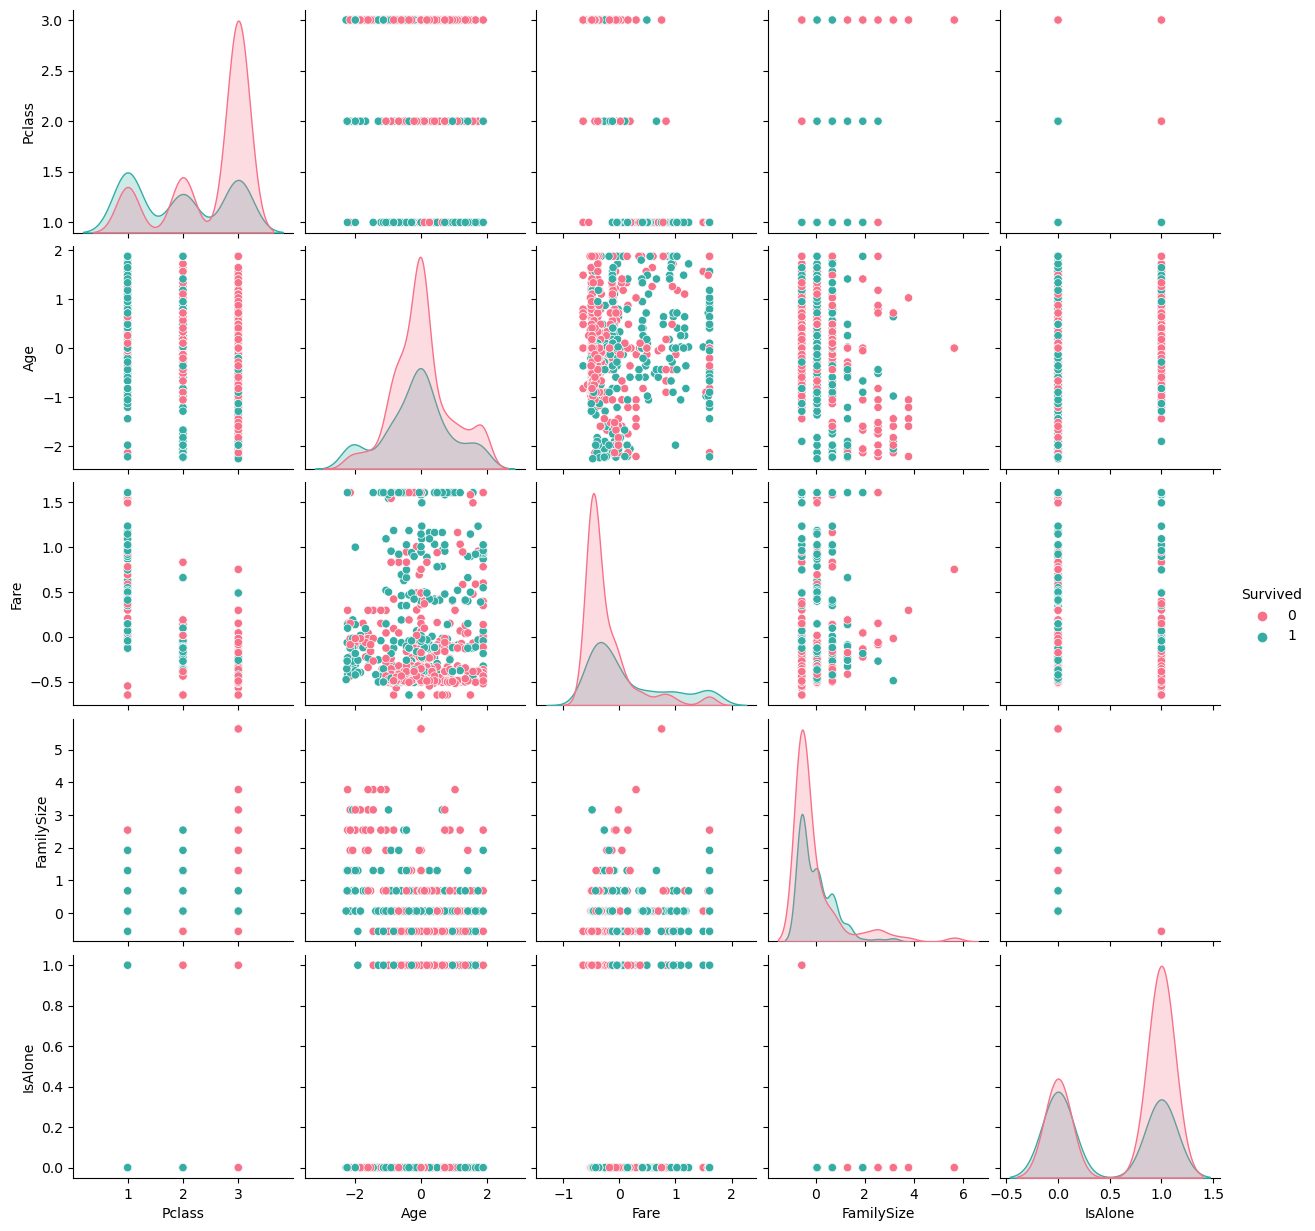

In [27]:
#Pairplot for key Relationships
sns.pairplot(data[['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone']], hue='Survived', palette='husl')
plt.show()
#save the pairplot
sns.pairplot(data[['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone']], hue='Survived', palette='husl').savefig("pairplot.png",dpi=300)

In [24]:
## 🔍 Summarized Insights  

#1️⃣ **Age Distribution:** Most passengers were between 20-40 years old, with a few extreme outliers above 60.  
#2️⃣ **Survival Rate:** Higher survival rates were observed among females and passengers in higher classes.  
#3️⃣ **Fare Analysis:** Fare shows a right-skewed distribution — most passengers paid under $50, but a few paid significantly more.  
#4️⃣ **Correlation Findings:** Strong positive correlation between `Fare` and `Pclass` suggests wealthier passengers booked higher classes.  
